In [4]:
import sys 
sys.path.append('src')

In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms

# Pennylane
import pennylane as qml
from quantum_circuit import Quantumnet

# Other tools
import time

# Modular
from dataset import get_data_transforms, get_dataloaders
# from utils import imshow, plot_tensorboard_metric
from training import train_model, save_model, load_model, visualize_model


env: OMP_NUM_THREADS=1


In [71]:
base_model = 'resnet18'
n_qubits = 2                     # Number of qubits
quantum = False                   # If set to "False", the dressed quantum circuit is replaced by 
                                 # An enterily classical net (defined by the next parameter). 
classical_model = '512_nq_2'     # Possible choices: '512_2','512_nq_2','551_512_2'. 
# step = 0.0004                    # Learning rate quantum 2em
step = 0.0009# classic 2em
batch_size = 4                   # Number of samples for each training step
num_epochs = 20                  # Number of training epochs
q_depth = 3                      # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights
rng_seed = 0                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

In [72]:
# Quantum device - PennyLane
dev = qml.device('default.qubit', wires=n_qubits)
# Classical device - GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {device}")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

✅ Usando dispositivo: cuda:0
NVIDIA GeForce RTX 4070 Laptop GPU


In [73]:
data_dir = 'CremaD/mel_spec_reduced_HAP_SAD'

dataloaders, dataset_sizes, class_names = get_dataloaders(
    data_dir=data_dir, batch_size=batch_size, shuffle=True, spec_augment=True
)

n_classes = len(class_names)

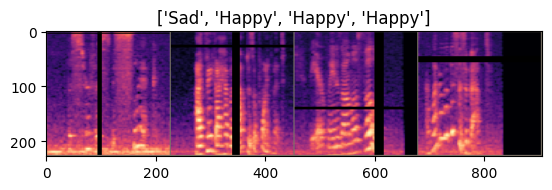

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [74]:
if base_model == 'resnet18':
    model_hybrid = torchvision.models.resnet18(pretrained=True)

    for param in model_hybrid.parameters():
        param.requires_grad = False

    if quantum:
        model_hybrid.fc = Quantumnet(
            n_qubits=n_qubits,
            q_depth=q_depth,
            max_layers=max_layers,
            q_delta=q_delta,
            dev=dev, 
            n_classes=n_classes
        )

    elif classical_model == '512_2':
        model_hybrid.fc = nn.Linear(512, n_classes)
        
    elif classical_model == '512_nq_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), 
                                        nn.Linear(n_qubits, n_qubits), torch.nn.ReLU(),
                                        nn.Linear(n_qubits, n_classes)) 

    elif classical_model == '551_512_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, n_classes))

elif base_model == 'vgg16':
    model_hybrid = torchvision.models.vgg16(pretrained=True)

    for param in model_hybrid.parameters():
        param.requires_grad = False

    if quantum:
        model_hybrid.classifier[6] = Quantumnet(
            n_qubits=n_qubits,
            q_depth=q_depth,
            max_layers=max_layers,
            q_delta=q_delta,
            dev=dev, 
            n_classes=n_classes,
            base_model=base_model
        )

    elif classical_model == '512_2':
        model_hybrid.classifier[6] = nn.Linear(4096, n_classes)
        
    elif classical_model == '512_nq_2':
        model_hybrid.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512), 
            torch.nn.ReLU(), 
            nn.Linear(512, n_qubits),
            torch.nn.ReLU(),
            nn.Linear(n_qubits, n_classes)
            ) 

    elif classical_model == '551_512_2':
        model_hybrid.classifier[6] = nn.Sequential(nn.Linear(4096, 512), torch.nn.ReLU(), nn.Linear(512, n_classes))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)
torch.manual_seed(rng_seed)

In [75]:
# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
params_to_optimize = (
    model_hybrid.fc.parameters() if base_model == 'resnet18'
    else model_hybrid.classifier[6].parameters()
)
optimizer_hybrid = optim.AdamW(params_to_optimize, lr=step)

# Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)


In [76]:
prefix = "q" if quantum else "cl"
timestamp = time.strftime('%Y%m%d_%H%M%S')
log_name = f"{prefix}_emotions_{base_model}_{timestamp}_final"
print(log_name)

writer = SummaryWriter(log_dir=f"runs/{log_name}")

model_hybrid = train_model(
    model=model_hybrid,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    criterion=criterion,
    optimizer=optimizer_hybrid,
    scheduler=exp_lr_scheduler,
    num_epochs=num_epochs, 
    writer=writer
)
writer.close()

cl_emotions_resnet18_20250724_212517_final
🚀 Training started:
Phase: train Epoch: 1/20 Loss: 0.6919 Acc: 0.5619: 0.0111s
Phase: val Epoch: 1/20 Loss: 0.6792 Acc: 0.5493: 0.0057s
Phase: train Epoch: 2/20 Loss: 0.6646 Acc: 0.6276: 0.0063s
Phase: val Epoch: 2/20 Loss: 0.6274 Acc: 0.7606: 0.0039s
Phase: train Epoch: 3/20 Loss: 0.6372 Acc: 0.6856: 0.0076s
Phase: val Epoch: 3/20 Loss: 0.5896 Acc: 0.8390: 0.0045s
Phase: train Epoch: 4/20 Loss: 0.5978 Acc: 0.7168: 0.0067s
Phase: val Epoch: 4/20 Loss: 0.5337 Acc: 0.8571: 0.0041s
Phase: train Epoch: 5/20 Loss: 0.5654 Acc: 0.7469: 0.0080s
Phase: val Epoch: 5/20 Loss: 0.4787 Acc: 0.8229: 0.0045s
Phase: train Epoch: 6/20 Loss: 0.5619 Acc: 0.7447: 0.0056s
Phase: val Epoch: 6/20 Loss: 0.4672 Acc: 0.8008: 0.0043s
Phase: train Epoch: 7/20 Loss: 0.5311 Acc: 0.7659: 0.0061s
Phase: val Epoch: 7/20 Loss: 0.4468 Acc: 0.8592: 0.0043s
Phase: train Epoch: 8/20 Loss: 0.5419 Acc: 0.7202: 0.0057s
Phase: val Epoch: 8/20 Loss: 0.4383 Acc: 0.8229: 0.0062s
Phase: tr

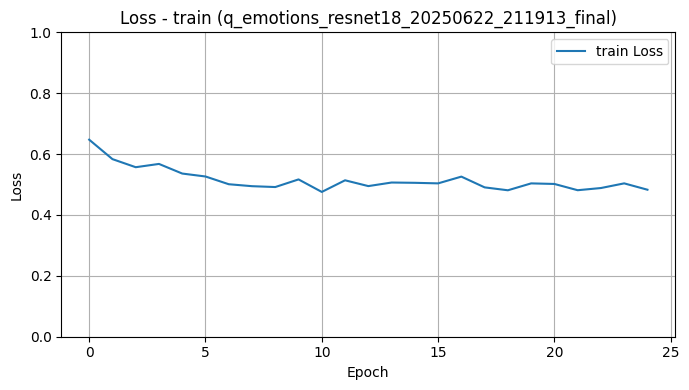

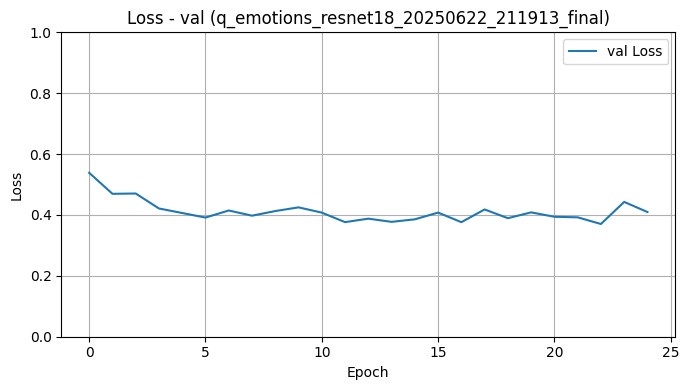

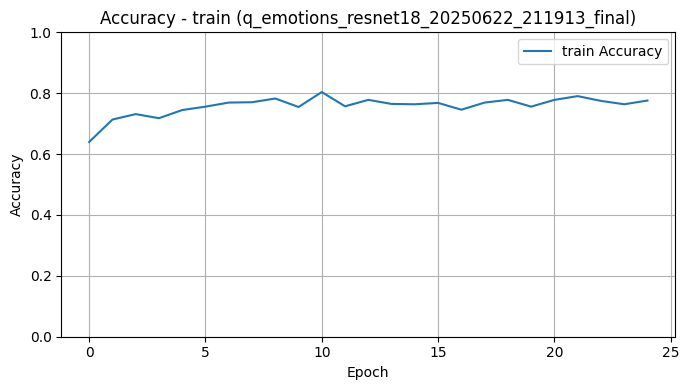

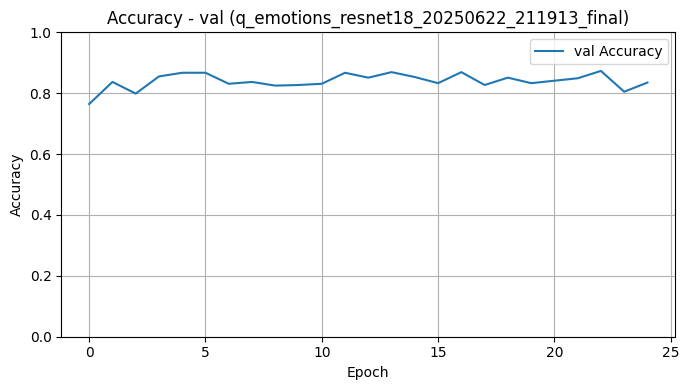

In [12]:
plot_tensorboard_metric(f"{log_name}", metric="Loss", phase="train")
plot_tensorboard_metric(f"{log_name}", metric="Loss", phase="val")
plot_tensorboard_metric(f"{log_name}", metric="Accuracy", phase="train")
plot_tensorboard_metric(f"{log_name}", metric="Accuracy", phase="val")

# plot_tensorboard_metric("q_emotions_resnet18_20250516_173726", metric="Loss", phase="val")
# plot_tensorboard_metric("q_emotions_vgg16_20250522_172130", metric="Accuracy", phase="train")
# plot_tensorboard_metric("q_emotions_vgg16_20250522_172130", metric="Accuracy", phase="val")

In [52]:
model_name = f"emotions_{base_model}_2407"
save_model(model_hybrid, quantum=quantum, name=model_name)

💾 Modelo guardado en: models\q_emotions_resnet18_2407.pt


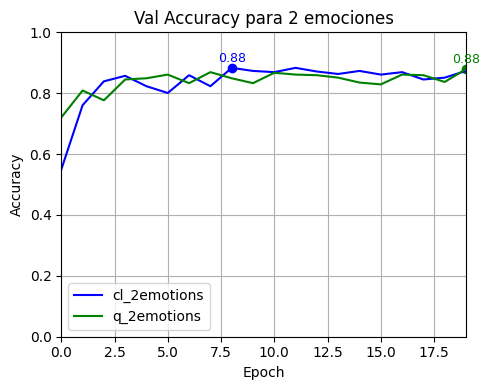

In [82]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# -----------------------------------------------------
# 🗂️ Lista con las subcarpetas de tus 4 ejecuciones
# (relativas a la carpeta 'runs')
# -----------------------------------------------------
classes_to_plot = 2
run_names = [
    f"cl_{classes_to_plot}emotions",
    f"q_{classes_to_plot}emotions"
]

# Ruta base donde están guardadas las ejecuciones
runs_base_path = "runs/best_runs"

# -------------------------------
# 🎯 Extraer y graficar accuracies
# -------------------------------
plt.figure(figsize=(5, 4))
plt.title(f"Val Accuracy para {classes_to_plot} emociones")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(0, 19)
plt.ylim(0, 1)
plt.grid(True)

# Colores para cada curva
colors = ['blue', 'green', 'red', 'purple']

for i, run_name in enumerate(run_names):
    run_path = os.path.join(runs_base_path, run_name)

    # Buscar archivo de eventos
    event_file = next(
        (os.path.join(run_path, f) for f in os.listdir(run_path) if f.startswith("events.out.tfevents")),
        None
    )
    if event_file is None:
        print(f"⚠️ No se encontró archivo de eventos en {run_path}")
        continue

    # Cargar datos con EventAccumulator
    ea = event_accumulator.EventAccumulator(event_file)
    ea.Reload()

    tag = "val/Accuracy"
    if tag not in ea.Tags().get("scalars", []):
        print(f"⚠️ La métrica {tag} no existe en {run_name}")
        continue

    # Obtener valores y epochs
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]

    # Marcar máximo
    max_acc = max(values)
    max_epoch = steps[values.index(max_acc)]

    plt.plot(steps, values, label=run_name, color=colors[i])
    plt.scatter(max_epoch, max_acc, color=colors[i], marker='o')
    plt.text(max_epoch, max_acc + 0.02, f"{max_acc:.2f}", fontsize=9, ha='center', color=colors[i])

# -------------------------------
# 🧾 Finalizar gráfico
# -------------------------------
plt.legend()
plt.tight_layout()
plt.show()


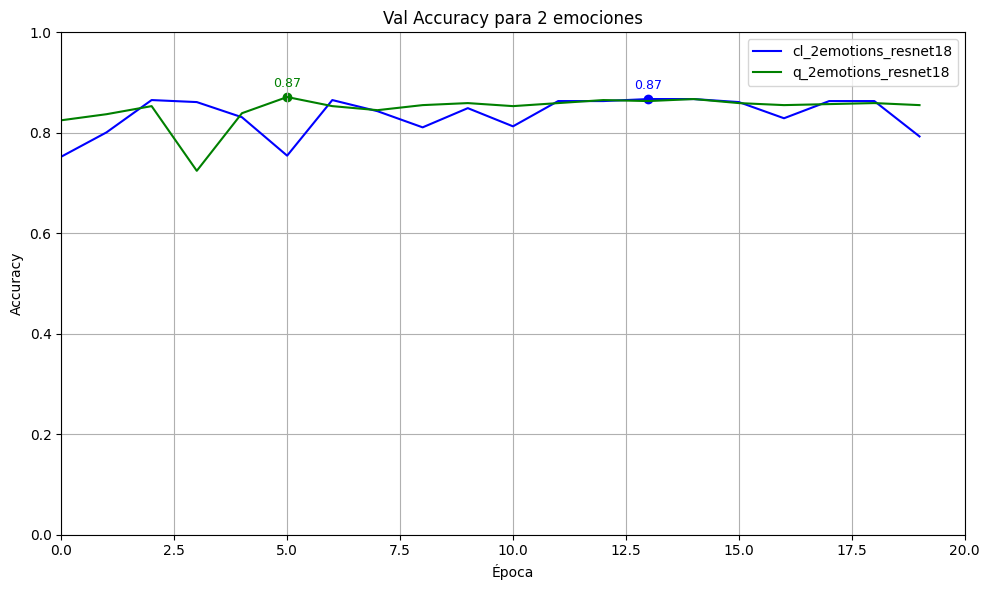

In [3]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# -----------------------------------------------------
# 🗂️ Lista con las 2 ejecuciones a comparar
# -----------------------------------------------------
classes_to_plot = 2
run_names = [
    f"cl_{classes_to_plot}emotions_resnet18",
    f"q_{classes_to_plot}emotions_resnet18"
]

# Ruta base donde están guardadas las ejecuciones
runs_base_path = "runs/best_runs"

# -------------------------------
# 🎯 Extraer y graficar accuracies
# -------------------------------
plt.figure(figsize=(10, 6))
plt.title("Val Accuracy para 2 emociones")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.grid(True)

# Colores para cada curva
colors = ['blue', 'green']

for i, run_name in enumerate(run_names):
    run_path = os.path.join(runs_base_path, run_name)

    # Buscar archivo de eventos
    event_file = next(
        (os.path.join(run_path, f) for f in os.listdir(run_path) if f.startswith("events.out.tfevents")),
        None
    )
    if event_file is None:
        print(f"⚠️ No se encontró archivo de eventos en {run_path}")
        continue

    # Cargar datos
    ea = event_accumulator.EventAccumulator(event_file)
    ea.Reload()

    tag = "val/Accuracy"
    if tag not in ea.Tags().get("scalars", []):
        print(f"⚠️ La métrica {tag} no existe en {run_name}")
        continue

    # Obtener valores y epochs
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]

    # Marcar máximo
    max_acc = max(values)
    max_epoch = steps[values.index(max_acc)]

    plt.plot(steps, values, label=run_name, color=colors[i])
    plt.scatter(max_epoch, max_acc, color=colors[i], marker='o')
    plt.text(max_epoch, max_acc + 0.02, f"{max_acc:.2f}", fontsize=9, ha='center', color=colors[i])

# -------------------------------
# 🧾 Finalizar gráfico
# -------------------------------
plt.legend()
plt.tight_layout()
plt.show()
